# Install Determined
https://docs.determined.ai/latest/setup-cluster/basic.html

# Install Pachyderm
https://docs.pachyderm.com/latest/set-up/local-deploy/

# Confirm that Determined and Pachyderm are installed and connected

In [4]:
!det version

client:
  version: 0.22.1
master:
  cluster_id: 6964d299-204d-4da9-a5ff-454d70e60a15
  cluster_name: ''
  master_id: 60150f6d-beae-4f84-99ab-5b43df29d446
  telemetry:
    enabled: true
    otel_enabled: false
    otel_endpoint: ''
    segment_key: Ryn8Uh9BYKJ4m9irA3MCzxcfHuB3CaaF
  version: 0.22.1
master_address: localhost:8080



In [2]:
!pachctl version

COMPONENT           VERSION             
pachctl             2.6.0               
pachd               2.6.0               


# Create a Pachyderm project for batch inferencing
Creating a project will encapsulate all of our training/inferencing repos and pipelines.

In [29]:
!pachctl create project batch-inference-1

In [30]:
!pachctl config update context --project batch-inference-1

editing the currently active context "http://localhost:80"


# Create repos for training data
The training data is split 80:20 train/test into data used to train and data used to validate the model

In [31]:
!pachctl create repo test

In [32]:
!pachctl create repo train

In [33]:
!pachctl list repo

PROJECT           NAME  CREATED       SIZE (MASTER) DESCRIPTION 
batch-inference-1 train 2 seconds ago ≤ 0B                      
batch-inference-1 test  5 seconds ago ≤ 0B                      


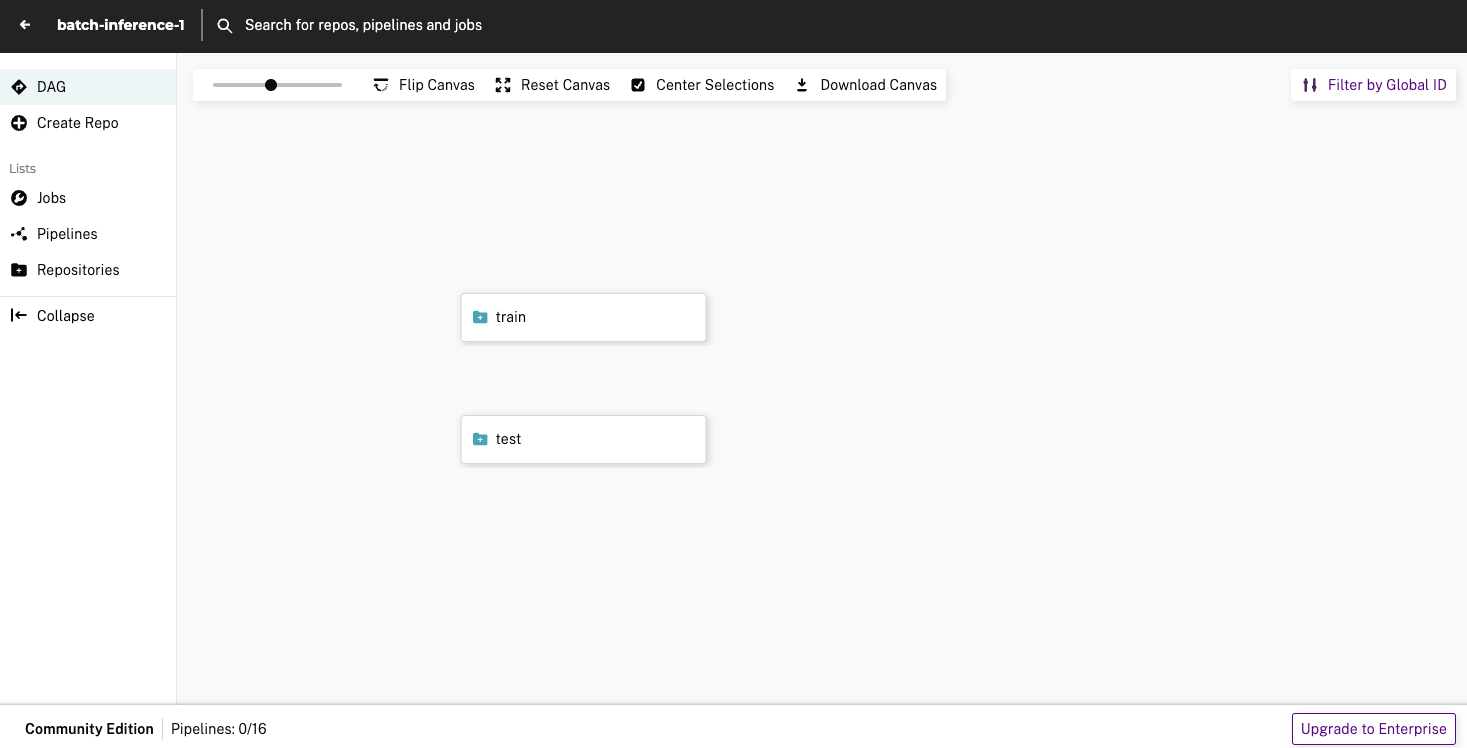

# Create a pipeline for training data
Our pipeline will merge the data from the train/test repos and compress them into a tar file for easy data access. This would also be a good place to do any data cleanup or transformations.

In [34]:
!pachctl create pipeline -f ./pachyderm/pipelines/compress/compress.json

In [36]:
!pachctl list pipeline

PROJECT           NAME     VERSION INPUT                                                  CREATED       STATE / LAST JOB  DESCRIPTION                                                          
batch-inference-1 compress 1       (batch-inference-1/train:/ ⨯ batch-inference-1/test:/) 8 seconds ago running / success A pipeline that compresses images from the train and test data sets. 


In [37]:
!pachctl list repo

PROJECT           NAME     CREATED        SIZE (MASTER) DESCRIPTION                                          
batch-inference-1 compress 11 seconds ago ≤ 0B          Output repo for pipeline batch-inference-1/compress. 
batch-inference-1 train    19 seconds ago ≤ 0B                                                               
batch-inference-1 test     22 seconds ago ≤ 0B                                                               


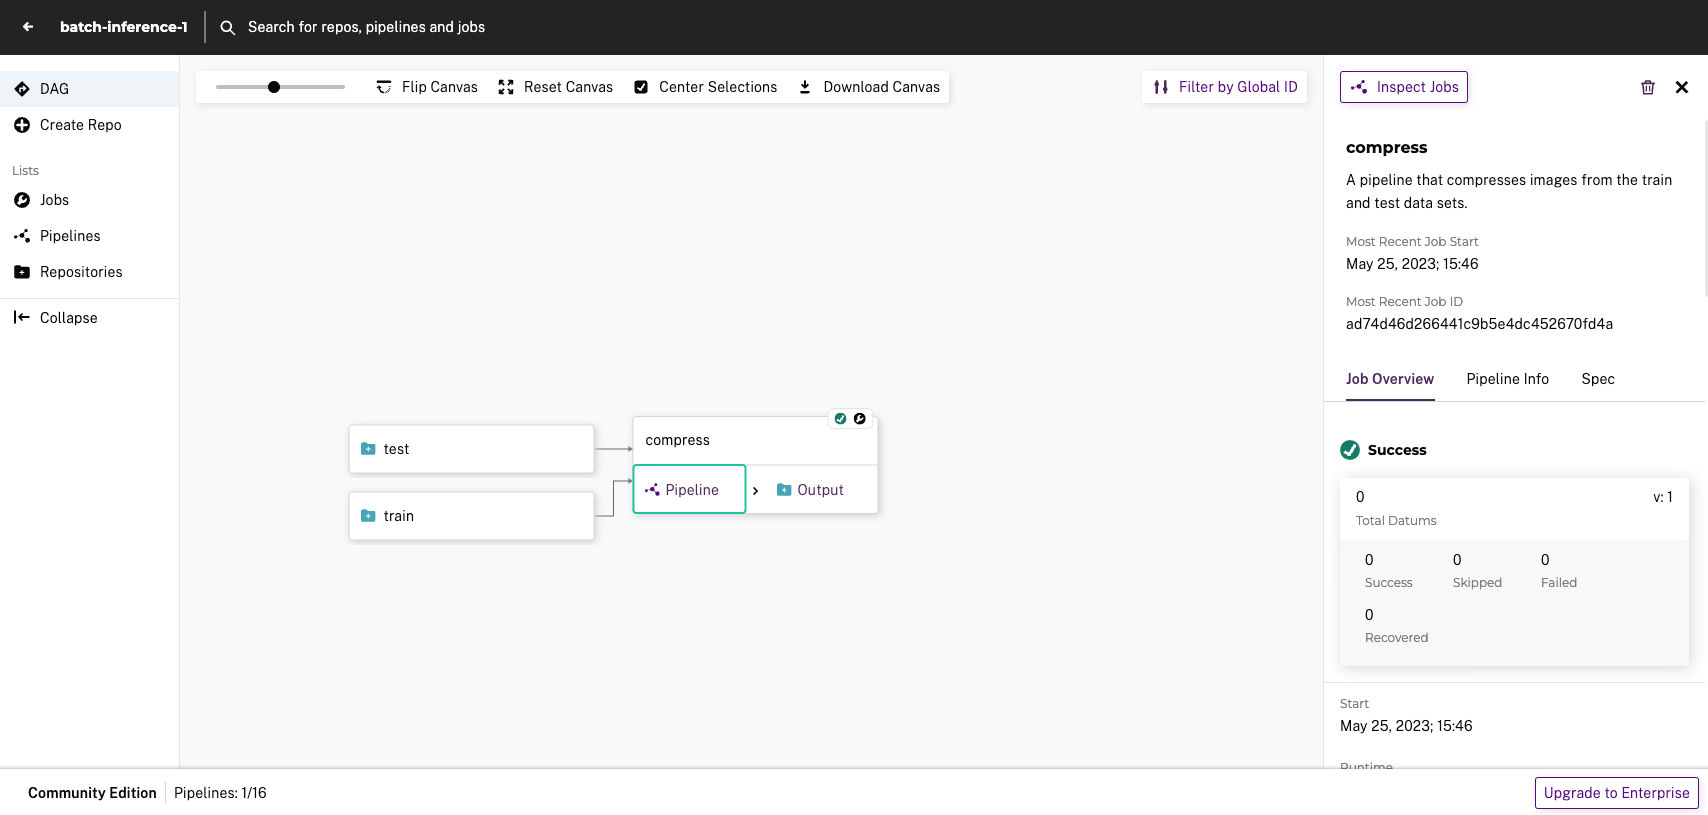

# Add data to the train and test repos
Adding files to the train or test repos will send them through the compress pipeline and produce a single tar file.

In [ ]:
!pachctl put file -r train@master:/ -f ./data/train_1000

In [ ]:
!pachctl put file -r test@master:/ -f ./data/test_1000

In [13]:
!pachctl list file train@master

NAME        TYPE SIZE     
/cat.0.jpg  file 12.12KiB 
/cat.1.jpg  file 16.48KiB 
/cat.10.jpg file 33.51KiB 
/cat.11.jpg file 21.77KiB 
/cat.12.jpg file 11.83KiB 
/cat.13.jpg file 11.22KiB 
/cat.14.jpg file 13.18KiB 
/cat.15.jpg file 20.09KiB 
/cat.16.jpg file 18.04KiB 
/cat.17.jpg file 31.32KiB 
/cat.18.jpg file 29.41KiB 
/cat.19.jpg file 12.4KiB  
/cat.2.jpg  file 24.11KiB 
/cat.20.jpg file 21.53KiB 
/cat.21.jpg file 33.54KiB 
/cat.22.jpg file 28.55KiB 
/cat.23.jpg file 13.53KiB 
/cat.24.jpg file 21.87KiB 
/cat.25.jpg file 21.74KiB 
/cat.26.jpg file 20.05KiB 
/cat.27.jpg file 26.35KiB 
/cat.28.jpg file 9.179KiB 
/cat.29.jpg file 25.16KiB 
/cat.3.jpg  file 37.08KiB 
/cat.30.jpg file 12.4KiB  
/cat.31.jpg file 28.3KiB  
/cat.32.jpg file 28.66KiB 
/cat.33.jpg file 19.57KiB 
/cat.34.jpg file 24.82KiB 
/cat.35.jpg file 29.09KiB 
/cat.36.jpg file 22.63KiB 
/cat.37.jpg file 19.72KiB 
/cat.38.jpg file 15.25KiB 
/cat.39.jpg file 14.66KiB 
/cat.4.jpg  file 20.14KiB 
/cat.5.jpg  file 5.256KiB 
/

In [14]:
!pachctl list file test@master

NAME           TYPE SIZE     
/cat.10000.jpg file 21.43KiB 
/cat.10001.jpg file 26.68KiB 
/cat.10002.jpg file 25.12KiB 
/cat.10003.jpg file 27.38KiB 
/cat.10004.jpg file 12.67KiB 
/cat.10005.jpg file 8.052KiB 
/cat.10006.jpg file 23.59KiB 
/cat.10008.jpg file 24.63KiB 
/cat.10009.jpg file 20.78KiB 
/cat.10462.jpg file 14.19KiB 
/dog.10380.jpg file 25.99KiB 
/dog.10381.jpg file 21.8KiB  
/dog.10382.jpg file 23.36KiB 
/dog.10383.jpg file 4.332KiB 
/dog.10384.jpg file 9.997KiB 
/dog.10385.jpg file 1.602KiB 
/dog.10386.jpg file 33.37KiB 
/dog.10387.jpg file 17.1KiB  
/dog.10388.jpg file 17.2KiB  
/dog.10389.jpg file 17.14KiB 


In [15]:
!pachctl list file compress@master

NAME               TYPE SIZE     
/compressed.tar.gz file 2.078MiB 


# Use the compress repo data to train our models
We'll use a Determined cluster to train our model based on the data stored and versioned in Pachyderm. We'll need to tell Determined the Pachyderm host, port, project, repo, and commit so it knows where to download the data we care about. Grab the commit you are interested in and replace it in the configuration below.

In [1]:
!cat ./determined/train.yaml

description: catdog_single_train
data:
  pachyderm:
    host: localhost
    port: 80
    project: catdog
    repo: compress
    commit: fbc3668bd5434ba6b918b07290371207
hyperparameters:
  learning_rate: 0.005
  global_batch_size: 16
  weight_decay: 1.0e-4
  nesterov: true
searcher:
  name: single
  metric: accuracy
  max_length:
    batches: 200
  smaller_is_better: false
entrypoint: model_def:CatDogModel
scheduling_unit: 10
min_validation_period:
  batches: 100


In [33]:
!det experiment create ./determined/train.yaml ./determined

Preparing files to send to master... 12.5KB and 6 files
Created experiment 75


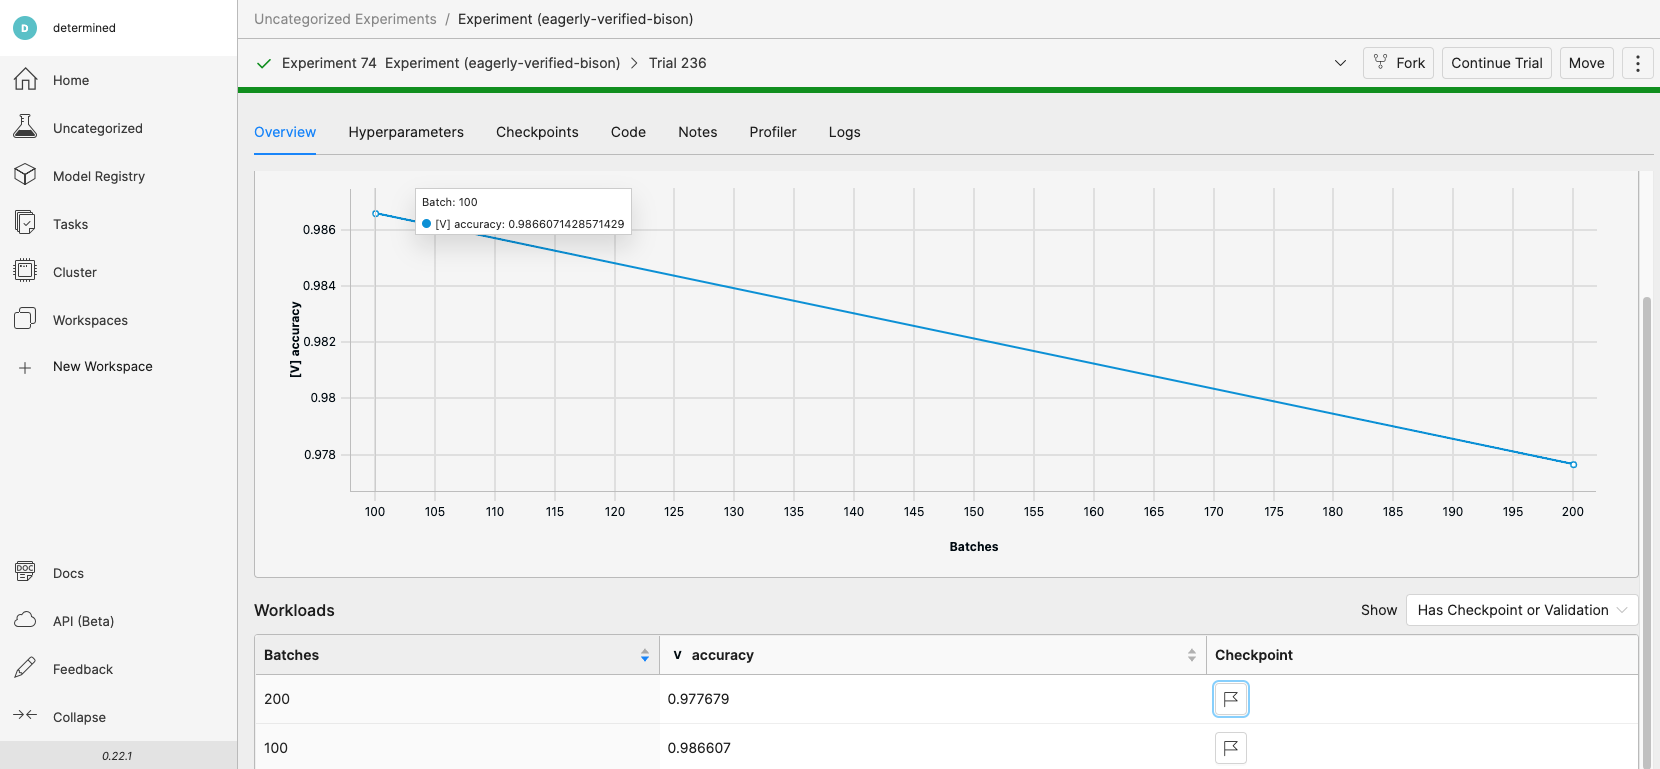

# Download checkpoints from Determined
Once we are happy with our model's performance, we will download checkpoints and put them in Pachyderm repos.

In [40]:
!det checkpoint download 127a88a7-2e4d-4906-ba99-a32a86c269ec -o ./data/checkpoints/catdog100

Local checkpoint path:
data/checkpoints/catdog10 

   Experiment ID |   Trial ID |   Steps Completed | Report Time              | Checkpoint UUID                      | Validation Metrics                      | Metadata
-----------------+------------+-------------------+--------------------------+--------------------------------------+-----------------------------------------+--------------------------------------
              74 |        236 |               200 | 2023-05-22 06:35:20+0000 | 127a88a7-2e4d-4906-ba99-a32a86c269ec | {                                       | {
                 |            |                   |                          |                                      |     "avgMetrics": {                     |     "determined_version": "0.22.1",
                 |            |                   |                          |                                      |         "accuracy": 0.9776785714285714, |     "format": "pickle",
                 |            |         

In [43]:
!pachctl create repo models

In [41]:
!pachctl list repo

PROJECT           NAME     CREATED            SIZE (MASTER) DESCRIPTION                                          
batch-inference-1 models   2 seconds ago      ≤ 0B                                                               
batch-inference-1 compress About a minute ago ≤ 21.14MiB    Output repo for pipeline batch-inference-1/compress. 
batch-inference-1 train    About a minute ago ≤ 17.36MiB                                                         
batch-inference-1 test     About a minute ago ≤ 4.207MiB                                                         


In [ ]:
!pachctl put file -r models@master:/catdog100 -f ./data/checkpoints/catdog100

In [ ]:
!pachctl put file -r models@master:/catdog1000 -f ./data/checkpoints/catdog1000

# Create a repo and pipeline for inferencing
Using the Determined model, we'll create a pipeline that can predict batches of files. We can also scale this step out by adding a parallelism_spec value to our pipeline spec. 

In [43]:
!pachctl create repo predict

In [21]:
!pachctl list repo

PROJECT         NAME     CREATED       SIZE (MASTER) DESCRIPTION                                        
batch-inference predict  3 seconds ago ≤ 0B                                                             
batch-inference models   4 minutes ago ≤ 359.5MiB                                                       
batch-inference compress 7 minutes ago ≤ 2.078MiB    Output repo for pipeline batch-inference/compress. 
batch-inference train    7 minutes ago ≤ 1.753MiB                                                       
batch-inference test     7 minutes ago ≤ 376.4KiB                                                       


In [50]:
!pachctl create pipeline -f ./pachyderm/pipelines/predict/predict.json

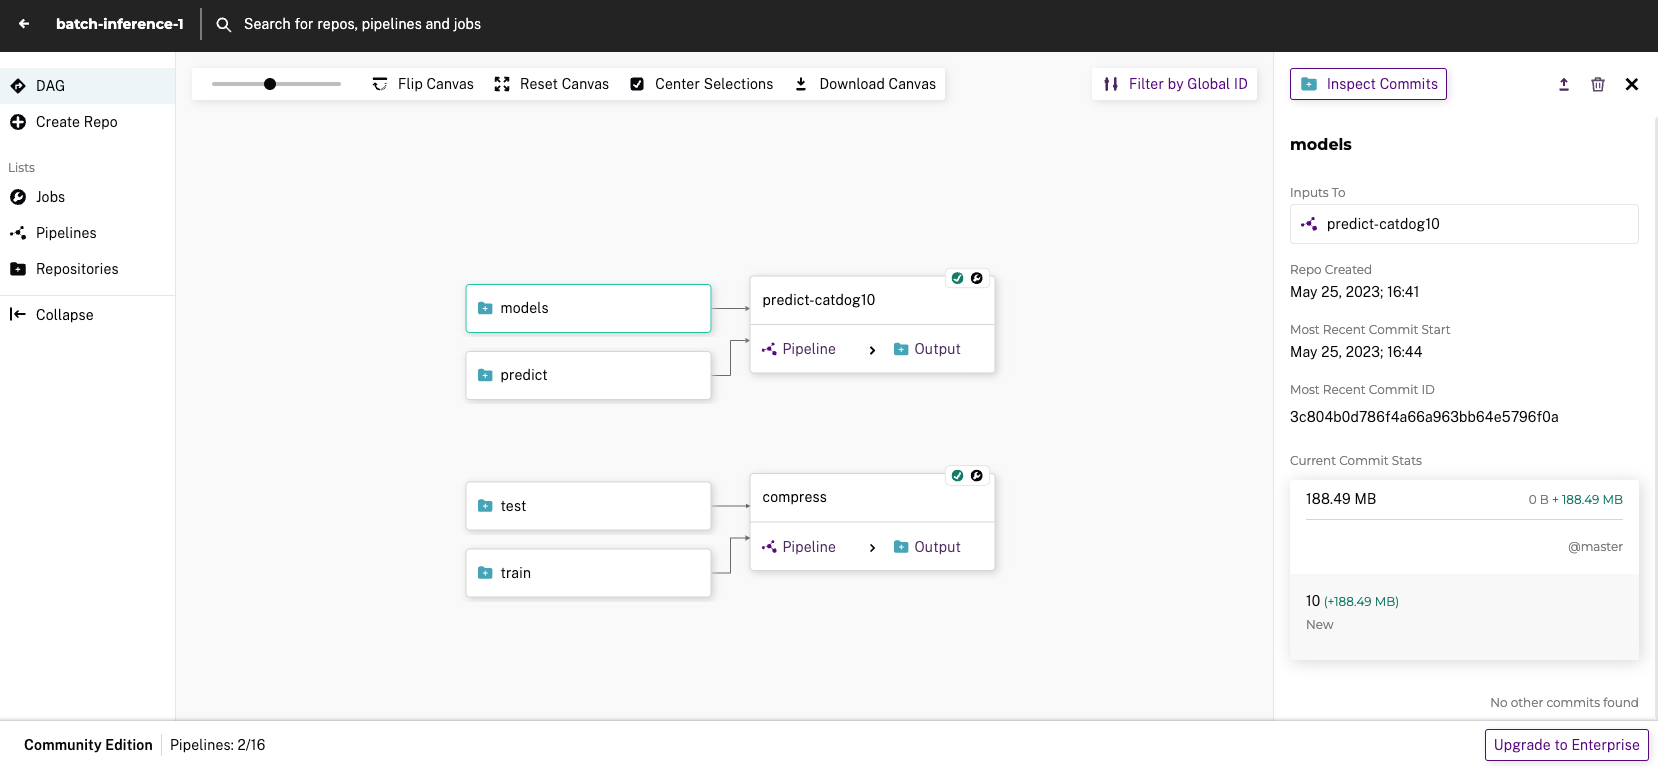

# Add some files for Pachyderm/Determined to inference
We can add any number of files to the predict repo at any time. Our pipelines will both generate an image as output and store the results in a database.

In [ ]:
!pachctl put file -r predict@master -f ./data/predict/batch_10

# Add a results pipeline
The results pipeline will collect all of the predctions and save the result to a database.

In [57]:
!pachctl create pipeline -f ./pachyderm/pipelines/results/results.json

# Add more files for to watch all of the pipelines run

In [ ]:
!pachctl put file -r predict@master -f ./data/predict/batch_5_2

# Add another model to watch it smartly process the prediction data
When the new model is added, all of the previously inferenced datums are processed against the new model.

In [ ]:
!pachctl put file -r models@master:/catdog10 -f ./data/checkpoints/catdog10